In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_excel('cleaned_df.xlsx')

In [3]:
df.head()

,Unnamed: 0,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,...,MarkDown5,CPI,Unemployment,Type,Size,year,week,Type_A,Type_B,Type_C
0,0,1,1,2010-02-05,24924.50,0,42.31,2.572,0.0,0.0,...,0.0,211.096358,8.106,A,151315,2010,5,1,0,0
1,1,1,1,2010-02-12,46039.49,1,38.51,2.548,0.0,0.0,...,0.0,211.242170,8.106,A,151315,2010,6,1,0,0
2,2,1,1,2010-02-19,41595.55,0,39.93,2.514,0.0,0.0,...,0.0,211.289143,8.106,A,151315,2010,7,1,0,0
3,3,1,1,2010-02-26,19403.54,0,46.63,2.561,0.0,0.0,...,0.0,211.319643,8.106,A,151315,2010,8,1,0,0
4,4,1,1,2010-03-05,21827.90,0,46.50,2.625,0.0,0.0,...,0.0,211.350143,8.106,A,151315,2010,9,1,0,0


In [4]:
df.drop('Unnamed: 0', axis = 1, inplace = True)

In [5]:
# Since we have encoded this variable so we no longer need this variable
df.drop('Type', axis = 1, inplace = True)

### Feature Engineering

Before we train the model, we should do feature engineering in which we make some features by using existing features. Well we can skip this but determining some new features can bring more accuracy in the model's results.

In [7]:
original_df = df.copy()

In [8]:
# month feature
df['month'] = df['Date'].dt.month

In [9]:
# promotion impact flags
df['Any_MarkDown'] = df[['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']].sum(axis=1) > 0
df['Any_MarkDown'] = df['Any_MarkDown'].astype(int)

df['Promo_Holiday'] = df['Any_MarkDown'] * df['IsHoliday']

`Promo_Holiday` feature represents whether the markdown (promotion) was applied in holiday week 

In [11]:
df.head(3)

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,...,Unemployment,Size,year,week,Type_A,Type_B,Type_C,month,Any_MarkDown,Promo_Holiday
0,1,1,2010-02-05,24924.50,0,42.31,2.572,0.0,0.0,0.0,...,8.106,151315,2010,5,1,0,0,2,0,0
1,1,1,2010-02-12,46039.49,1,38.51,2.548,0.0,0.0,0.0,...,8.106,151315,2010,6,1,0,0,2,0,0
2,1,1,2010-02-19,41595.55,0,39.93,2.514,0.0,0.0,0.0,...,8.106,151315,2010,7,1,0,0,2,0,0


We don't need to drop the `NaN` values or replace them with mean because the random forest regressor models have the ability to handle the missing values by itself

### Model Training

We will train our model on complete dataset. The reason behind using Random Forest model is that as we have seen previously that the relationship between the predictors and the target variable is not linear so we cannot use regression models here and we are predicting weekly sales which can be affected by factors like:
- Store size and type
- Promotions (markdowns)
- Weather (temperature and fuel price) and etc.

and these factors likely interact in complex and non-linear ways.

But we will also be checking Regression model and will compare it with random forest model

In [14]:
df.columns

Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday', 'Temperature',
       'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4',
       'MarkDown5', 'CPI', 'Unemployment', 'Size', 'year', 'week', 'Type_A',
       'Type_B', 'Type_C', 'month', 'Any_MarkDown', 'Promo_Holiday'],
      dtype='object')

In [15]:
# drop unnecessary columns
df.drop('Date', axis = 1, inplace = True)

Dropping `Date` column seems appropriate here because we have already extracted week numbers and months and year like features. We will use whole dataset for training the model

In [17]:
train_x = df.drop('Weekly_Sales', axis = 1)
train_y = df['Weekly_Sales']

## Random Forest Regressor Model

In [19]:
# Fit your model on whole dataset
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators= 100, random_state = 42, n_jobs = -1)
model.fit(train_x, train_y)

RandomForestRegressor(n_jobs=-1, random_state=42)

let's import the testing dataset

In [21]:
test_df = pd.read_csv('test.csv')

In [22]:
test_df.shape

(115064, 4)

In [23]:
test_df.head()

,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False


Well here we have only 4 columns and we had so many features like fuel, temperture and etc, to train the model. So we have other files in which these additional features exist so we need to import those datasets and merge with `test_df`

In [25]:
features = pd.read_csv('features.csv')
stores = pd.read_csv('stores.csv')

In [26]:
features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


Looks like we need to do some data cleaning

In [28]:
stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [29]:
# first merge test_df with features dataset
x = pd.merge(test_df, features, on = ['Store', 'Date', 'IsHoliday'], how = 'left')

# then merge the result with stores dataset
test_final_df = pd.merge(x, stores, on = 'Store', how = 'left')
test_final_df.head()

,Store,Dept,Date,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2012-11-02,False,55.32,3.386,6766.44,5147.70,50.82,3639.90,2737.42,223.462779,6.573,A,151315
1,1,1,2012-11-09,False,61.24,3.314,11421.32,3370.89,40.28,4646.79,6154.16,223.481307,6.573,A,151315
2,1,1,2012-11-16,False,52.92,3.252,9696.28,292.10,103.78,1133.15,6612.69,223.512911,6.573,A,151315
3,1,1,2012-11-23,True,56.23,3.211,883.59,4.17,74910.32,209.91,303.32,223.561947,6.573,A,151315
4,1,1,2012-11-30,False,52.34,3.207,2460.03,NaN,3838.35,150.57,6966.34,223.610984,6.573,A,151315


In [30]:
test_final_df.isnull().sum()

Store               0
Dept                0
Date                0
IsHoliday           0
Temperature         0
Fuel_Price          0
MarkDown1         149
MarkDown2       28627
MarkDown3        9829
MarkDown4       12888
MarkDown5           0
CPI             38162
Unemployment    38162
Type                0
Size                0
dtype: int64

In [31]:
test_final_df['MarkDown1'] = test_final_df['MarkDown1'].fillna(0)
test_final_df['MarkDown2'] = test_final_df['MarkDown2'].fillna(0)
test_final_df['MarkDown3'] = test_final_df['MarkDown3'].fillna(0)
test_final_df['MarkDown4'] = test_final_df['MarkDown4'].fillna(0)

cpi_mean = test_final_df['CPI'].mean()
test_final_df['CPI'].replace(np.nan, cpi_mean, inplace = True)

test_final_df['Unemployment'].replace(np.nan, test_final_df['Unemployment'].mean(), inplace = True)

C:\Users\PMLS\AppData\Local\Temp\ipykernel_97020\4188254941.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_final_df['CPI'].replace(np.nan, cpi_mean, inplace = True)
C:\Users\PMLS\AppData\Local\Temp\ipykernel_97020\4188254941.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a co

In [32]:
test_final_df.isnull().sum()

Store           0
Dept            0
Date            0
IsHoliday       0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
Type            0
Size            0
dtype: int64

Null values are removed. Now before predicting the weekly sales, we need to enhance the features and make the features which we made in training set

In [34]:
test_final_df['IsHoliday'] = test_final_df['IsHoliday'].astype('int')

In [35]:
dummies = pd.get_dummies(test_final_df['Type'], dtype  = 'int', prefix = 'Type')

In [36]:
test_final_df  = pd.concat([test_final_df, dummies], axis = 1)
test_final_df.head()

,Store,Dept,Date,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Type_A,Type_B,Type_C
0,1,1,2012-11-02,0,55.32,3.386,6766.44,5147.70,50.82,3639.90,2737.42,223.462779,6.573,A,151315,1,0,0
1,1,1,2012-11-09,0,61.24,3.314,11421.32,3370.89,40.28,4646.79,6154.16,223.481307,6.573,A,151315,1,0,0
2,1,1,2012-11-16,0,52.92,3.252,9696.28,292.10,103.78,1133.15,6612.69,223.512911,6.573,A,151315,1,0,0
3,1,1,2012-11-23,1,56.23,3.211,883.59,4.17,74910.32,209.91,303.32,223.561947,6.573,A,151315,1,0,0
4,1,1,2012-11-30,0,52.34,3.207,2460.03,0.00,3838.35,150.57,6966.34,223.610984,6.573,A,151315,1,0,0


In [37]:
test_final_df.drop(['Type'], axis = 1, inplace = True)

In [38]:
test_final_df['Date'] = pd.to_datetime(test_final_df['Date'])

In [39]:
test_final_df['month'] = test_final_df['Date'].dt.month
test_final_df['year'] = test_final_df['Date'].dt.year
test_final_df['week'] = test_final_df['Date'].dt.isocalendar().week

In [40]:
# promotion impact flags
test_final_df['Any_MarkDown'] = test_final_df[['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']].sum(axis=1) > 0
test_final_df['Any_MarkDown'] = test_final_df['Any_MarkDown'].astype(int)

test_final_df['Promo_Holiday'] = test_final_df['Any_MarkDown'] * test_final_df['IsHoliday']

In [41]:
test_final_df.head()

,Store,Dept,Date,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,...,Unemployment,Size,Type_A,Type_B,Type_C,month,year,week,Any_MarkDown,Promo_Holiday
0,1,1,2012-11-02,0,55.32,3.386,6766.44,5147.70,50.82,3639.90,...,6.573,151315,1,0,0,11,2012,44,1,0
1,1,1,2012-11-09,0,61.24,3.314,11421.32,3370.89,40.28,4646.79,...,6.573,151315,1,0,0,11,2012,45,1,0
2,1,1,2012-11-16,0,52.92,3.252,9696.28,292.10,103.78,1133.15,...,6.573,151315,1,0,0,11,2012,46,1,0
3,1,1,2012-11-23,1,56.23,3.211,883.59,4.17,74910.32,209.91,...,6.573,151315,1,0,0,11,2012,47,1,1
4,1,1,2012-11-30,0,52.34,3.207,2460.03,0.00,3838.35,150.57,...,6.573,151315,1,0,0,11,2012,48,1,0


In [78]:
test_final_df.drop('Date', axis =1, inplace = True)

In [98]:
# Make sure test set columns are in same order as training
test_final_df = test_final_df[train_x.columns]
test_final_df.head(3)

,Store,Dept,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,...,Unemployment,Size,year,week,Type_A,Type_B,Type_C,month,Any_MarkDown,Promo_Holiday
0,1,1,0,55.32,3.386,6766.44,5147.70,50.82,3639.90,2737.42,...,6.573,151315,2012,44,1,0,0,11,1,0
1,1,1,0,61.24,3.314,11421.32,3370.89,40.28,4646.79,6154.16,...,6.573,151315,2012,45,1,0,0,11,1,0
2,1,1,0,52.92,3.252,9696.28,292.10,103.78,1133.15,6612.69,...,6.573,151315,2012,46,1,0,0,11,1,0


`test_final_df` is completely unseen data and we need to predict weekly_sales of using features of this unseen data. But we haven't checked that how our model will actually perform to unseen data so must check it to get an idea that how our model will perform to completely unseen data like `test_final_df`.

In [101]:
x = df.drop('Weekly_Sales', axis = 1)
y = df['Weekly_Sales']

In [105]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.20, random_state = 42)

In [107]:
from sklearn.ensemble import RandomForestRegressor

Model = RandomForestRegressor(n_estimators= 100, random_state = 42, n_jobs = -1)
Model.fit(x_train, y_train)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [109]:
predict = Model.predict(x_test)

In [120]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mae = mean_absolute_error(y_test, predict)
mse = mean_squared_error(y_test, predict)
r2 = r2_score(y_test, predict)

print(f"Mean Absolute Error: {mae}")
print(f"Mean squared Error: {mse}")
print(f"R squared: {r2}")

Mean Absolute Error: 1445.3965309912946
Mean squared Error: 13446201.3051946
R squared: 0.9742148624010873


when we look at r2_score we can see that our model explains 97.42% of variation in the target variable `Weekly_Sales` and a large portion of variation has been explained which means that our model is reliable and fits the data very well.

**MAE = 1445** it indicates that our model's predictions are off by about 1445 units from the actual values. This is straightforward measure, the lower the better.

**MSE = 13446201.30** This is the average of squared differences between the actual and predicted values.

The large value of MSE would be because of some terms that might be outliers but overall our model explains 97% of variation in the target variable and it performs better.

#### Feature Importance
It is useful to check the importances of features in the model and it helps us to see on what feature(s) the model rely on

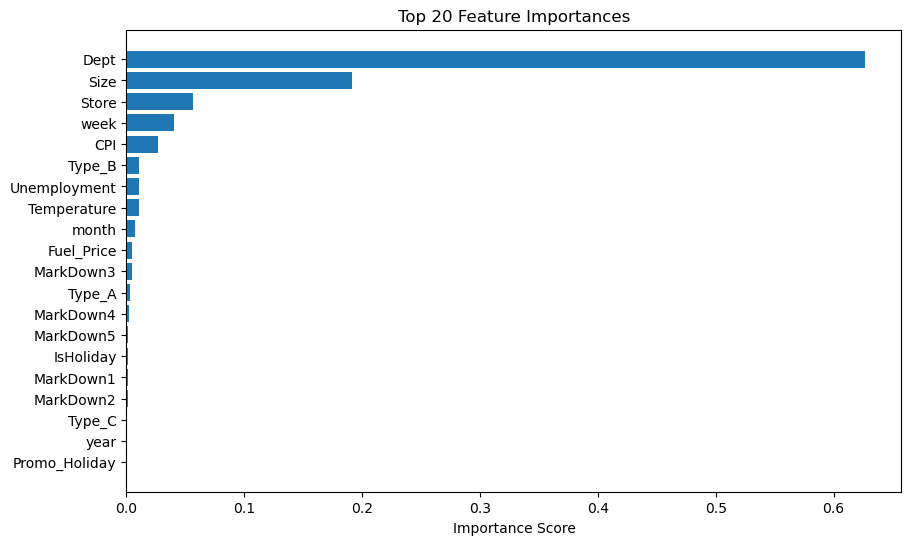

In [124]:
# Get feature importances
importances = Model.feature_importances_
features = x_train.columns

# Put into DataFrame for sorting and plotting
feat_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feat_df = feat_df.sort_values(by='Importance', ascending=False)

# Plot top features
plt.figure(figsize=(10, 6))
plt.barh(feat_df['Feature'][:20], feat_df['Importance'][:20])
plt.gca().invert_yaxis()
plt.title("Top 20 Feature Importances")
plt.xlabel("Importance Score")
plt.show()

The above graph shows that `Dept` and `Store` are strong predictors and contribute to the weekly sales the most and model is capturing store-dept sales patterns. While on the other hand, `size` contributes to the model too. The stores with larger sizes perform better.

The remaining features contributes very low and have very small importance and markdown columns also do not have significant importance while they should have and it might be because the dataset contained 60% missing data of markdown features.

Now we can use the model to predict weekly_sales for the unseen data as we have checked the performance of the model.

In [130]:
# predicting weekly_sales by using the model which we trained by using complete trained_dataset
pred = model.predict(test_final_df)

In [134]:
pred

array([32285.7377, 18748.1071, 19505.39  , ...,   400.5557,   407.8631,
         399.5409])

In [150]:
series = pd.Series(pred, index = test_final_df.index, name = 'Predicted_weekly_sales')
result_df = pd.concat([test_final_df, series], axis = 1)
result_df.head()

,Store,Dept,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,...,Size,year,week,Type_A,Type_B,Type_C,month,Any_MarkDown,Promo_Holiday,Predicted_weekly_sales
0,1,1,0,55.32,3.386,6766.44,5147.70,50.82,3639.90,2737.42,...,151315,2012,44,1,0,0,11,1,0,32285.7377
1,1,1,0,61.24,3.314,11421.32,3370.89,40.28,4646.79,6154.16,...,151315,2012,45,1,0,0,11,1,0,18748.1071
2,1,1,0,52.92,3.252,9696.28,292.10,103.78,1133.15,6612.69,...,151315,2012,46,1,0,0,11,1,0,19505.3900
3,1,1,1,56.23,3.211,883.59,4.17,74910.32,209.91,303.32,...,151315,2012,47,1,0,0,11,1,1,21006.3369
4,1,1,0,52.34,3.207,2460.03,0.00,3838.35,150.57,6966.34,...,151315,2012,48,1,0,0,11,1,0,22043.7982


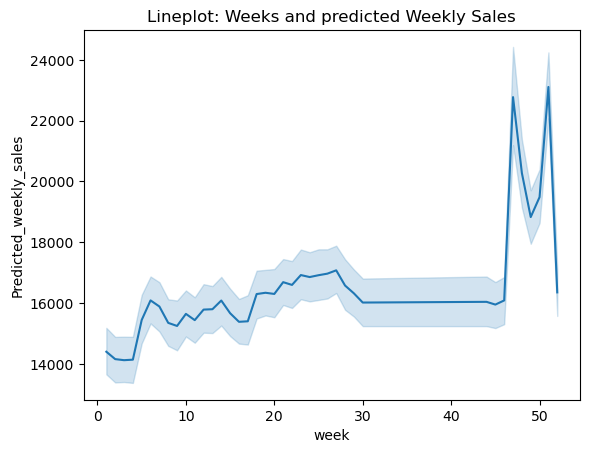

In [152]:
sns.lineplot(data = result_df, x = 'week', y = 'Predicted_weekly_sales')
plt.title('Lineplot: Weeks and predicted Weekly Sales')
plt.show()

So we have computed and predicted the weekly sales for the unseen data by using random forest regressor and also has done model evaluation and looks like this model perfroms better. As discussed earlier we will compare randomforest model with the regression model to check which model performs better overall. So let's move on to predict weekly sales by using regression.

In [161]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

Since we have already used train_test_split function above to split the datset so we will use those same train and test datasets for training and testing the model

In [176]:
mdl = LinearRegression()

In [178]:
mdl.fit(x_train, y_train)

LinearRegression()

In [180]:
Predictions = mdl.predict(x_test)

In [182]:
MAE = mean_absolute_error(y_test, Predictions)
MSE = mean_squared_error(y_test, Predictions)
R2 = r2_score(y_test, Predictions)

print(f"Mean Absolute Error: {MAE}")
print(f"Mean squared Error: {MSE}")
print(f"R squared: {r2}")

Mean Absolute Error: 14560.467567521871
Mean squared Error: 473169494.1520826
R squared: 0.9742148624010873


Surprisingly Linear Regression model also explains the same amount of variation as does the Random Forest model, it explains about 97% of the variation.

**MAE= 14560** it indicates that on the average the model's predictions are off about 14,560 units - which are larger in magnitude as compared to the Random Forest model, and the reason might be that the linear regression model will be failing to capture non-linear relationships.

**MSE = 473169494** The squared error between the actual values and the predicted values and is larger in magnitude and it is because the predicted values would be much far away from the actual values because of non-linear relationship curve.

Overall, we should prefer the RandomForest Regressor model because it is reliable and it is performing better even though the relationship is non-linear and that's the ability of random forest regressor that it can perform well when the relationships are not linear between variables. On the other hand, Linear Regression model gives a larger Mean Absolute error and Mean Squared error as compared to Random Forest Regressor model.

___

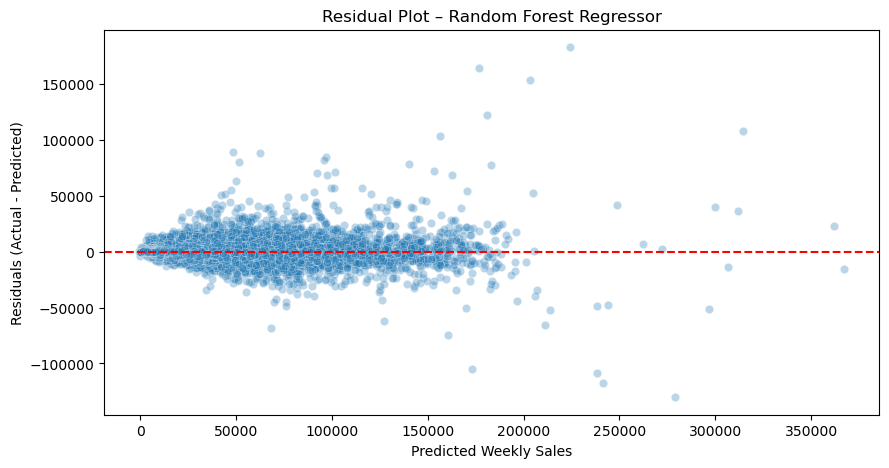

In [190]:
y_true = y_test
y_pred = predict

residuals = y_true - y_pred

# Plot residuals
plt.figure(figsize=(10, 5))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.3)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Weekly Sales')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residual Plot – Random Forest Regressor')
plt.show()

All the points are scatterd randomly around zero which fulfills the assumption of homoscedasticity but we see some points far away from 0 which means that our model either overestimated or underestimated weekly_sales for those rows.

This is a healthy residual plot — the Random Forest is performing strongly overall, and any remaining error is likely due to natural sales volatility, special events, or rare department/store combinations.

___